In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# For data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns; 
from sklearn.model_selection import train_test_split
from pylab import rcParams

from scipy import stats
from collections import Counter

# for modeling 
import sklearn
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_precision_recall_curve, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score,  accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


# Plotly for interactive graphics 
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv


In [2]:
data = pd.read_csv('/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv')

In [3]:
df =data.copy()

In [4]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
df.shape

(145460, 23)

In [6]:
nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

,Missing_Records,Percentage (%)
Sunshine,69835,48.009762
Evaporation,62790,43.166506
Cloud3pm,59358,40.807095
Cloud9am,55888,38.421559
Pressure9am,15065,10.356799
Pressure3pm,15028,10.331363
WindDir9am,10566,7.263853
WindGustDir,10326,7.098859
WindGustSpeed,10263,7.055548
Humidity3pm,4507,3.098446


In [7]:
df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)
df[['RainToday', 'RainTomorrow']].isnull().sum()

RainToday       0
RainTomorrow    0
dtype: int64

In [8]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    display(str.sort_values(by='Nulls', ascending=False))

summary(df)

Data shape: (140787, 23)
___________________________
Data Types:
float64    16
object      7
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
Sunshine,float64,73982,146,66805,0.0,14.5
Evaporation,float64,81093,356,59694,0.0,145.0
Cloud3pm,float64,84693,11,56094,0.0,9.0
Cloud9am,float64,88162,11,52625,0.0,9.0
Pressure3pm,float64,127018,549,13769,977.1,1039.6
Pressure9am,float64,127044,546,13743,980.5,1041.0
WindDir9am,object,131127,17,9660,NaN,NaN
WindGustDir,object,131624,17,9163,NaN,NaN
WindGustSpeed,float64,131682,68,9105,6.0,135.0
WindDir3pm,object,137117,17,3670,NaN,NaN


In [9]:
df[['RainToday','RainTomorrow']] = df[['RainToday','RainTomorrow']].replace({'Yes':1, 'No':0})

In [10]:
df.dropna(inplace=True)

In [11]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Year'] = df['Date'].dt.year.astype('int16')
df['Month'] = df['Date'].dt.month.astype('int16')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month
6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0,2009,1
6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0,2009,1
6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0,2009,1
6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0,2009,1
6054,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,...,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0,2009,1


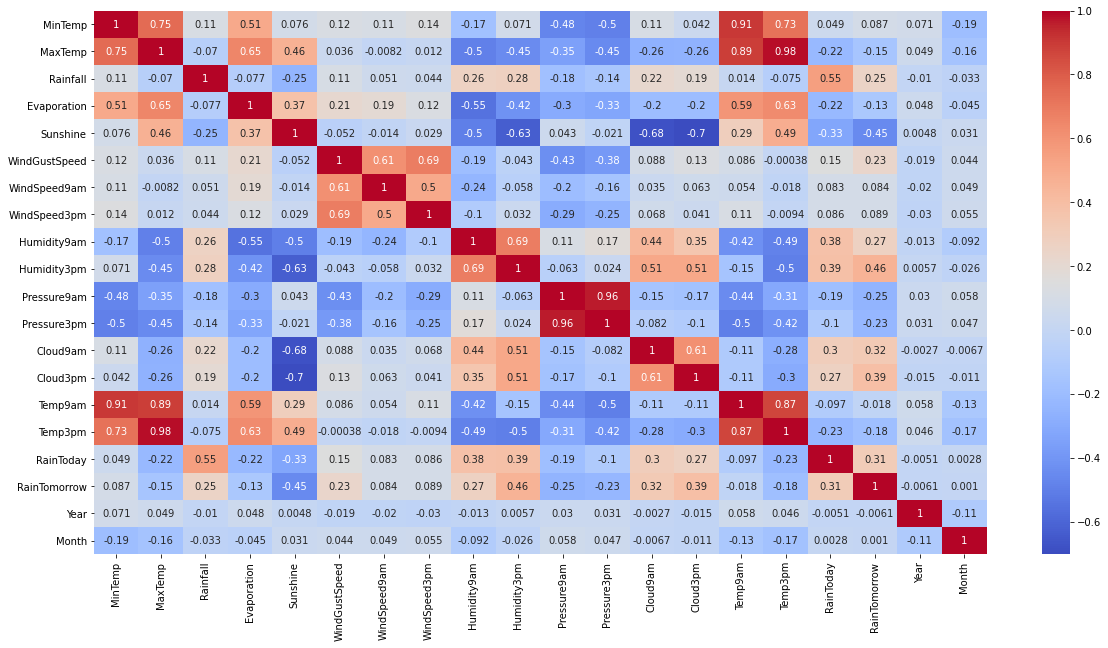

In [12]:
# for all variables 
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True, cmap="coolwarm");

In [13]:
df.isnull().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
Year             0
Month            0
dtype: int64

In [14]:
df.drop(columns="Date", axis=1, inplace=True)

In [15]:
df.sample(10)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month
64975,MelbourneAirport,10.6,24.8,0.0,4.2,10.4,S,31.0,N,S,...,1019.8,1017.0,4.0,5.0,13.9,21.5,0,0,2011,2
33866,SydneyAirport,20.2,26.1,0.0,8.4,11.1,SE,43.0,S,SE,...,1016.4,1015.4,2.0,1.0,22.7,25.0,0,0,2009,12
32051,Sydney,8.0,19.2,0.0,1.6,8.0,S,43.0,W,S,...,1013.5,1012.2,1.0,2.0,9.6,16.1,0,1,2013,6
94550,Townsville,18.5,25.6,3.8,1.0,7.6,SW,39.0,SW,SSW,...,1018.5,1015.4,7.0,5.0,18.7,25.5,1,0,2012,6
34449,SydneyAirport,11.2,18.4,6.4,2.2,9.7,NNE,56.0,NNW,W,...,1008.6,1008.8,3.0,3.0,13.9,17.2,1,0,2011,8
13317,Moree,-0.4,15.3,0.0,3.2,9.4,SSW,33.0,SSW,SW,...,1025.4,1023.6,0.0,0.0,5.9,14.6,0,0,2012,7
141706,Darwin,26.3,34.2,0.4,4.4,10.0,NNW,35.0,N,NW,...,1011.8,1007.8,4.0,7.0,30.7,33.7,0,0,2015,11
119396,PerthAirport,20.0,30.3,0.0,9.6,10.7,SW,43.0,NNW,WSW,...,1007.3,1006.3,6.0,1.0,26.3,28.4,0,0,2014,1
6192,Cobar,13.2,22.9,0.0,4.0,9.9,ENE,44.0,ENE,ENE,...,1021.2,1019.0,2.0,2.0,16.9,22.6,0,0,2009,5
94549,Townsville,19.0,23.5,0.8,4.2,0.0,ESE,28.0,SW,S,...,1016.6,1013.8,8.0,8.0,19.9,22.5,0,1,2012,6


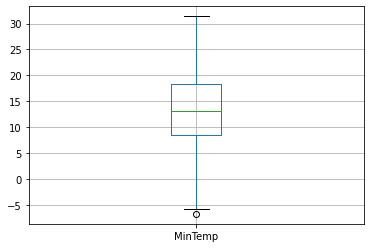

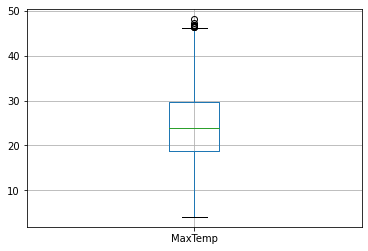

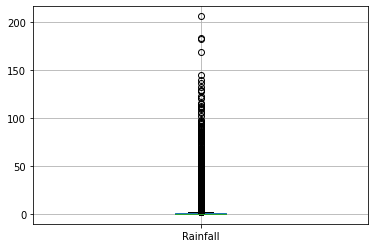

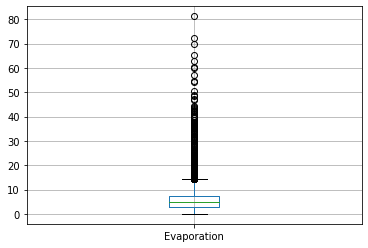

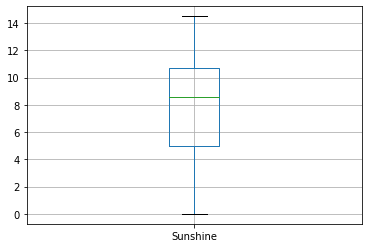

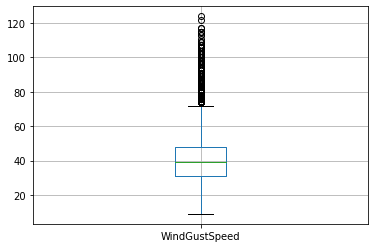

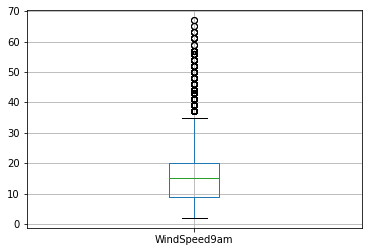

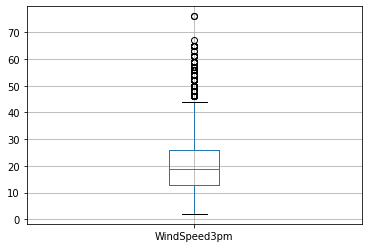

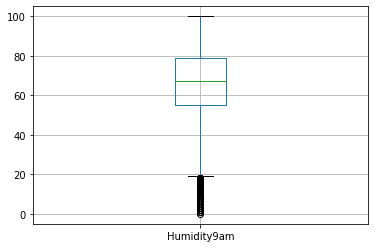

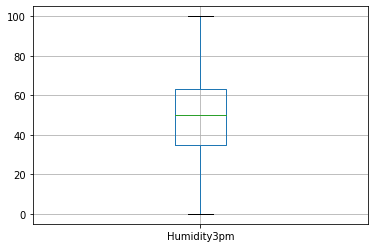

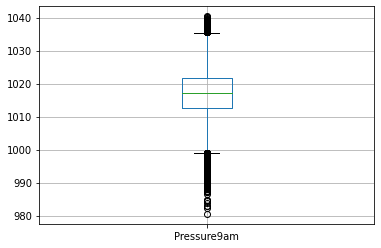

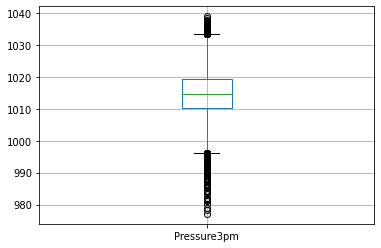

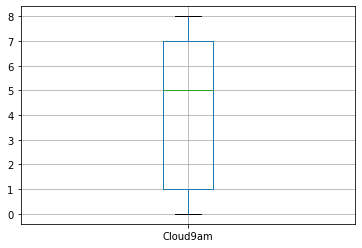

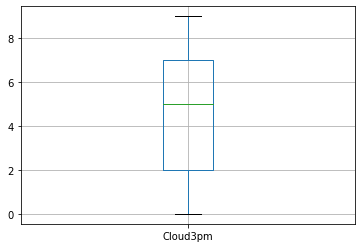

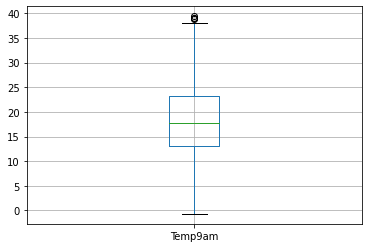

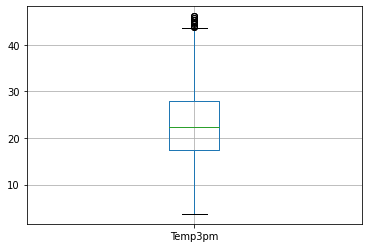

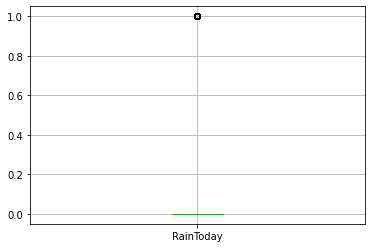

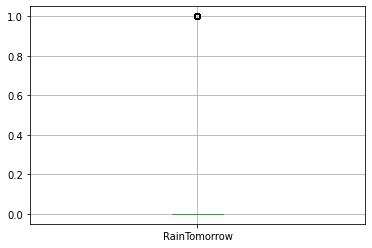

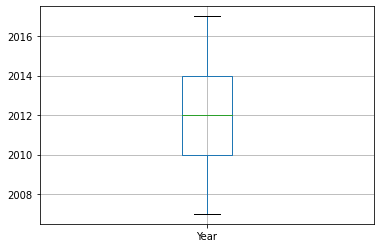

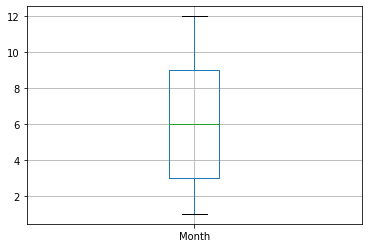

In [16]:
for i in df.select_dtypes(include=np.number).columns.tolist():
    plt.figure()
    df.boxplot([i])

In [17]:
df = pd.get_dummies(df, drop_first=True, columns = ['Location','WindGustDir','WindDir9am','WindDir3pm'])

# Outliers

In [18]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

y = df['RainTomorrow']
X = df.drop(['RainTomorrow'], axis=1)

clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.10, random_state=42)
clf.fit(X)
y_pred = clf.predict(X)

# the model will predict an inlier with a label of +1 and an outlier with a label of -1

outliers_values = X[clf.predict(X) == -1]
outliers_values

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
6049,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,...,0,0,0,0,0,0,1,0,0,0
6050,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,...,0,0,0,0,1,0,0,0,0,0
6052,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,...,1,0,0,0,0,0,0,0,0,0
6054,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,...,0,0,0,0,0,0,0,0,1,0
6055,27.1,36.1,0.0,13.0,0.0,43.0,7.0,20.0,26.0,19.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142228,20.6,21.9,23.4,6.4,0.0,52.0,22.0,31.0,95.0,95.0,...,0,0,1,0,0,0,0,0,0,0
142230,21.6,31.7,3.4,2.0,10.0,37.0,13.0,13.0,78.0,56.0,...,0,0,0,0,0,0,0,0,0,0
142231,24.3,32.7,0.0,4.0,10.9,28.0,11.0,13.0,80.0,55.0,...,0,0,0,0,0,0,0,0,0,0
142234,25.6,33.0,7.2,5.6,7.9,39.0,19.0,20.0,77.0,55.0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
outliers_values = X[clf.predict(X) == -1]
f"{len(outliers_values)} rows are outliers"

'5642 rows are outliers'

In [20]:
df = X.join(y)[clf.predict(X) == 1]
df

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainTomorrow
6053,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,...,0,0,0,0,0,0,0,0,1,0
6057,16.1,34.2,0.0,14.6,13.2,37.0,15.0,6.0,25.0,9.0,...,0,1,0,0,0,0,0,0,0,0
6060,20.9,37.8,0.0,12.8,13.2,30.0,11.0,7.0,27.0,9.0,...,0,0,0,0,0,0,0,0,0,0
6066,17.9,34.2,0.0,12.0,11.3,61.0,22.0,17.0,46.0,19.0,...,0,0,1,0,0,0,0,0,0,0
6068,23.3,39.4,4.8,12.0,10.9,59.0,19.0,17.0,54.0,14.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142298,19.3,33.4,0.0,6.0,11.0,35.0,9.0,20.0,63.0,32.0,...,0,0,0,0,0,0,0,0,0,0
142299,21.2,32.6,0.0,7.6,8.6,37.0,13.0,11.0,56.0,28.0,...,0,0,1,0,0,0,0,0,0,0
142300,20.7,32.8,0.0,5.6,11.0,33.0,17.0,11.0,46.0,23.0,...,0,0,0,0,0,0,1,0,0,0
142301,19.5,31.8,0.0,6.2,10.6,26.0,9.0,17.0,62.0,58.0,...,0,0,0,0,0,0,0,0,0,0


## Creating Models

In [21]:
# separating the dependent and independent data
X=df.drop(["RainTomorrow"], axis=1)
y=df["RainTomorrow"]

# the function train_test_split creates random data samples (default: 75-25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state =42)

# getting the shapes
print(f"""shape of X_train: {X_train.shape}
shape of X_test\t: {X_test.shape}
shape of y_train: {y_train.shape}
shape of y_test\t: {y_test.shape}""")

shape of X_train: (38083, 89)
shape of X_test	: (12695, 89)
shape of y_train: (38083,)
shape of y_test	: (12695,)


1. Logistic  Regression

In [22]:
logreg = LogisticRegression(solver='liblinear', random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

Confusion Matrix
-----------------------------------------------------


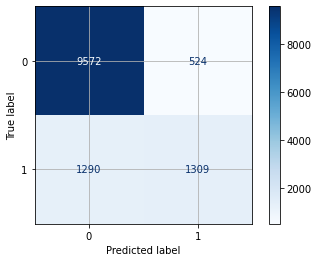



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     10096
           1       0.71      0.50      0.59      2599

    accuracy                           0.86     12695
   macro avg       0.80      0.73      0.75     12695
weighted avg       0.85      0.86      0.85     12695



ROC Curve
-----------------------------------------------------


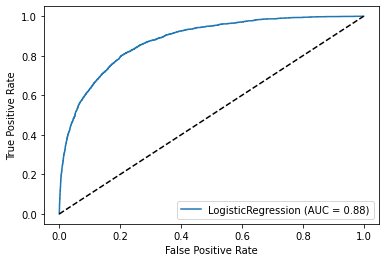



Checking model fitness
-----------------------------------------------------
Train score: 0.8608
Test score:  0.8571




In [23]:
def conf_matrix(model, X_test, y_test, cmap='Blues'):
    plot_confusion_matrix(model, X_test, y_test, cmap=cmap)
    plt.grid()
    plt.show()

def roc_curve_custom(model, X_test, y_test):
    plot_roc_curve(model, X_test, y_test)
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.show()
    
def evaluate(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, y_pred=y_pred):
    # Confusion Matrix
    print('Confusion Matrix')
    print('-'*53)
    conf_matrix(model, X_test, y_test)
    print('\n') 
    
    # Classification Report
    print('Classification Report') 
    print('-'*53)
    print(classification_report(y_test, y_pred))
    print('\n')
    
    # ROC Curve
    print('ROC Curve')
    print('-'*53)
    roc_curve_custom(model, X_test, y_test)
    print('\n')
    
    # Checking model fitness
    print('Checking model fitness') 
    print('-'*53)
    print('Train score:', round(model.score(X_train, y_train), 4))
    print('Test score: ', round(model.score(X_test, y_test), 4))
    print('\n')
    
evaluate(logreg)

In [24]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

print('Original')
print('-'*20)
print(y_train.value_counts())
print('\n')
print('SMOTE')
print('-'*20)
print(pd.Series(y_train_resampled).value_counts())

Original
--------------------
0    30285
1     7798
Name: RainTomorrow, dtype: int64


SMOTE
--------------------
0    30285
1    30285
Name: RainTomorrow, dtype: int64


In [25]:
logreg_smote = LogisticRegression(solver='liblinear', random_state=42)
logreg_smote.fit(X_train_resampled, y_train_resampled)
y_pred_smote = logreg_smote.predict(X_test)
y_pred_smote

array([0, 0, 0, ..., 0, 0, 0])

Confusion Matrix
-----------------------------------------------------


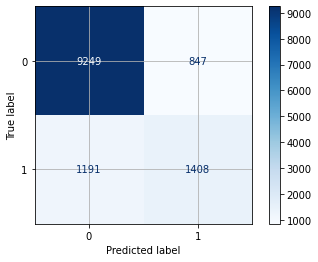



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     10096
           1       0.62      0.54      0.58      2599

    accuracy                           0.84     12695
   macro avg       0.76      0.73      0.74     12695
weighted avg       0.83      0.84      0.84     12695



ROC Curve
-----------------------------------------------------


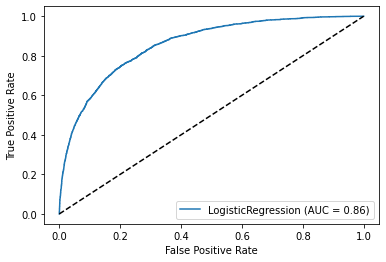



Checking model fitness
-----------------------------------------------------
Train score: 0.8967
Test score:  0.8395




In [26]:
evaluate(logreg_smote, X_train=X_train_resampled, y_train=y_train_resampled, y_pred=y_pred_smote)

### Tuning

In [27]:
logreg_params = {
    'C': [1, 1e8, 1e16],
    'fit_intercept': [True, False],
    'max_iter': [50, 100, 150],
    'random_state': [42]
}

logreg_tuned = GridSearchCV(logreg, logreg_params, scoring='accuracy', n_jobs=-1, cv=3)
logreg_tuned.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [1, 100000000.0, 1e+16],
                         'fit_intercept': [True, False],
                         'max_iter': [50, 100, 150], 'random_state': [42]},
             scoring='accuracy')

In [28]:
print("The best score:" + str(round(logreg_tuned.best_score_, 4)))
print("The best parameters: " + str(logreg_tuned.best_params_))

The best score:0.8593
The best parameters: {'C': 1, 'fit_intercept': True, 'max_iter': 50, 'random_state': 42}


In [29]:
y_pred_logreg_tuned = logreg_tuned.predict(X_test)
y_pred_logreg_tuned

array([0, 0, 0, ..., 0, 0, 0])

Confusion Matrix
-----------------------------------------------------


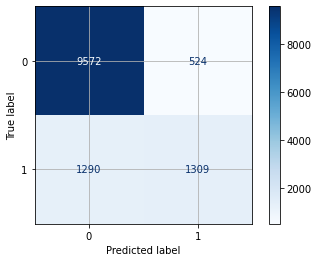



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     10096
           1       0.71      0.50      0.59      2599

    accuracy                           0.86     12695
   macro avg       0.80      0.73      0.75     12695
weighted avg       0.85      0.86      0.85     12695



ROC Curve
-----------------------------------------------------


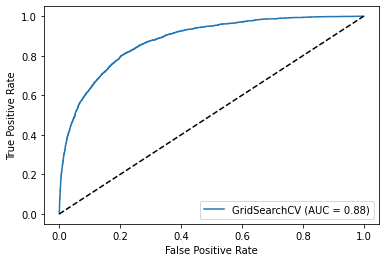



Checking model fitness
-----------------------------------------------------
Train score: 0.8608
Test score:  0.8571




In [30]:
evaluate(logreg_tuned, y_pred=y_pred_logreg_tuned)

# 2) Gaussian Naive Bayes 

In [31]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)
nb_model

GaussianNB()

In [32]:
y_pred = nb_model.predict(X_test)

Confusion Matrix
-----------------------------------------------------


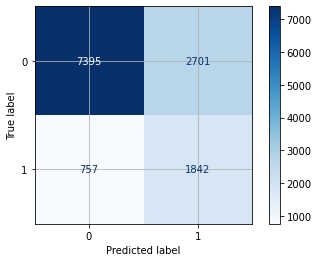



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.73      0.81     10096
           1       0.41      0.71      0.52      2599

    accuracy                           0.73     12695
   macro avg       0.66      0.72      0.66     12695
weighted avg       0.80      0.73      0.75     12695



ROC Curve
-----------------------------------------------------


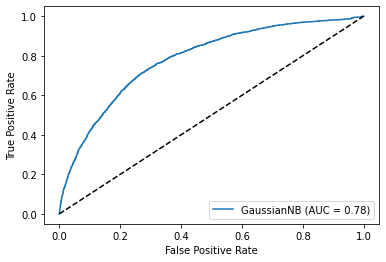



Checking model fitness
-----------------------------------------------------
Train score: 0.7248
Test score:  0.7276




In [33]:
evaluate(nb_model, y_pred=y_pred)

In [34]:
nb_finalscore=cross_val_score(nb_model, X_test, y_test, cv = 10).mean()
nb_finalscore

0.7271385491707154

## 3) KNN

In [35]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model = knn_model.fit(X_train, y_train)
# ?knn_model

In [36]:
y_pred = knn_model.predict(X_test)

In [37]:
accuracy_score(y_test, y_pred)

0.839070500196928

In [ ]:
evaluate(knn_model, y_pred=y_pred)

Confusion Matrix
-----------------------------------------------------


In [ ]:
# knn_params = {"n_neighbors": np.arange(1,50)}
# knn = KNeighborsClassifier()
# knn_cv = GridSearchCV(knn, knn_params, cv=10)
# knn_cv.fit(X_train, y_train)

In [ ]:
# print("The best score:" + str(knn_cv.best_score_))
# print("The best parameters: " + str(knn_cv.best_params_))

In [ ]:
knn_tuned =KNeighborsClassifier(n_neighbors = 37)
knn_tuned = knn_tuned.fit(X_train,y_train)
y_pred = knn_tuned.predict(X_test)

knn_tuned_score=accuracy_score(y_test,y_pred)
knn_tuned_score

In [ ]:
evaluate(knn_tuned, y_pred=y_pred)

## 4)SVM(SUPPORT VECTOR MACHINES)

In [ ]:
svm = SVC(C=5,degree=9,kernel = 'poly')
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)
?svm

In [ ]:
evaluate(svm, y_pred=y_pred)

In [ ]:
svc_params = {"C": [0.0001, 0.001, 0.1, 1, 5, 10 ,50 ,100],
             "gamma": [0.0001, 0.001, 0.1, 1, 5, 10 ,50 ,100],
              "kernel": ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
             }

In [ ]:
svc = SVC()
svc_cv_model = GridSearchCV(svc, svc_params, 
                         cv = 10, 
                         n_jobs = -1,
                         verbose = 2)

svc_cv_model.fit(X_train, y_train)

In [ ]:
print("The best parameters: " + str(svc_cv_model.best_params_))

In [ ]:
svc_tuned3 = SVC(C = 5, gamma =50).fit(X_train, y_train)
y_pred = svc_tuned3.predict(X_test)
svc_finalscore=accuracy_score(y_test, y_pred)
svc_finalscore

In [ ]:
evaluate(svc_tuned3, y_pred=y_pred)